In [1]:
import sys
sys.path.append('..')
sys.path.append('../../src/')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from os import path
from glob import glob

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv2D, SeparableConv2D, GlobalAvgPool2D, Dense, Dropout
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import Sequence

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from utils import load, plot
from local_config import FOLDER_IMAGES, FOLDER_MODELS
from global_config import RANDOM_SEED, IMAGE_SIZE
from custom_metrics import precision, recall, f1, specificity 
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from custom_metrics import equal_error_rate as eer

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
FILE_BASE_MODEL = '../../models/siamese_networks/model_2020_05_23-16_43_01.h5'
FOLDER_POS = "positives"
FOLDER_NEG = "negatives"

TEST_SIZE = 0.2
MLFLOW_EXPERIMENT_NAME = 'Siamese Networks'

print(FILE_BASE_MODEL)
print(FOLDER_IMAGES)
print(FOLDER_MODELS)

../../models/siamese_networks/model_2020_05_23-16_43_01.h5
../../data/siamese_networks
../../models/siamese_networks


In [3]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100)) 

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

# Triplet Generator 

In [4]:
class RandomTripletGenerator(Sequence):
    """Generate Random Triplets (A, P, N) for Siamese Networks on the fly"""
    def __init__(self, pos_files, neg_files, image_size, batch_size=1, datagen=ImageDataGenerator()):
        self.pos_files = pos_files
        self.neg_files = neg_files
        self.image_size = image_size
        self.batch_size = batch_size
        self.datagen = datagen
        
    def __len__(self):
        n_pos = len(self.pos_files)
        n_neg = len(self.neg_files)
        return min(n_pos, n_neg) // self.batch_size
    
    def __getitem__(self, idx):
        random_pos = np.random.choice(self.pos_files, size=self.batch_size, replace=False)
        random_neg = np.random.choice(self.neg_files, size=self.batch_size, replace=False)
        
        anchor_set = set(self.pos_files).difference(random_pos)
        random_anc = np.random.choice(list(anchor_set), size=self.batch_size, replace=False)
        
        anc_batch = load.images_from_list_files(random_anc, self.image_size, interpolation=cv2.INTER_AREA, show_progress=False)
        pos_batch = load.images_from_list_files(random_pos, self.image_size, interpolation=cv2.INTER_AREA, show_progress=False)
        neg_batch = load.images_from_list_files(random_neg, self.image_size, interpolation=cv2.INTER_AREA, show_progress=False)
        
        anc_batch = self.datagen.flow(anc_batch).next()
        pos_batch = self.datagen.flow(pos_batch).next()
        neg_batch = self.datagen.flow(neg_batch).next()
        
        return [anc_batch, pos_batch, neg_batch], None

# Triplet Loss 

In [5]:
def triplet_loss(y_pred, alpha=0.2):
    """
    Implementation of the triplet loss 
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images
            positive -- the encodings for the positive images
            negative -- the encodings for the negative images
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    pos_dist = tf.reduce_sum(tf.squared_difference(anchor, positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.squared_difference(anchor, negative), axis=-1)
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    
    return loss

# Load Base Model 

In [6]:
model = load_model(FILE_BASE_MODEL)

encoder = Model(inputs=model.inputs, outputs=model.get_layer(name='encoded').output)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
_________________________________________________________________
bn_2 (Batch

# Requirements

In [8]:
def build_requirements_model(base_model, name):
    set_random_seeds()
    
    req_emb = GlobalAvgPool2D()(base_model.output)
    req_emb = Dropout(rate=0.5)(req_emb)
    req_emb = Dense(units=128, activation='tanh', name=f'{name}_embeddings')(req_emb)
    req_model = Model(inputs=base_model.inputs, outputs=req_emb)

    for layer in req_model.layers:
        layer.trainable = (name in layer.name)

    return req_model


def build_siamese_model(req_model):
    input_anc = Input(shape=(*IMAGE_SIZE, 3))
    input_pos = Input(shape=(*IMAGE_SIZE, 3))
    input_neg = Input(shape=(*IMAGE_SIZE, 3))

    output_anc = req_model(input_anc)
    output_pos = req_model(input_pos)
    output_neg = req_model(input_neg)

    inputs = [input_anc, input_pos, input_neg]
    outputs = [output_anc, output_pos, output_neg]

    triplet_model = Model(inputs, outputs)
    triplet_model.add_loss(triplet_loss(outputs, alpha=2.0))
    triplet_model.compile(optimizer='adam', loss=None)

    return triplet_model


def train_embeddings(model, train_gen, valid_gen, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    
    list_callbacks = [
        EarlyStopping(monitor='val_loss', patience=50, verbose=1, restore_best_weights=True),
    ]
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.set_tag("requirement", name)
    mlflow.keras.autolog()

    hist = model.fit_generator(
        train_gen, 
        steps_per_epoch=100, 
        epochs=10, 
        validation_data=train_gen,
        validation_steps=10,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_embeddings(base_model, pos_files, neg_files, datagen, name):
    pos_train, pos_valid = train_test_split(pos_files, test_size=TEST_SIZE, random_state=RANDOM_SEED)
    neg_train, neg_valid = train_test_split(neg_files, test_size=TEST_SIZE, random_state=RANDOM_SEED)

    no_datagen = ImageDataGenerator(rescale=1 / 255)
    train_gen = RandomTripletGenerator(pos_train, neg_train, IMAGE_SIZE, datagen=datagen)
    valid_gen = RandomTripletGenerator(pos_valid, neg_valid, IMAGE_SIZE, datagen=no_datagen)
    
    req_model = build_requirements_model(encoder, name)
    triplet_model = build_siamese_model(req_model)

    hist, file_model = train_embeddings(triplet_model, train_gen, valid_gen, name)
    plot.keras_hist(hist.history)

    return file_model, req_model

#### 2. Blurred

In [ ]:
FOLDER_REQ = 'hat_cap'

pos_files = glob(f"{FOLDER_IMAGES}/{FOLDER_REQ}/{FOLDER_POS}/*")
neg_files = glob(f"{FOLDER_IMAGES}/{FOLDER_REQ}/{FOLDER_NEG}/*")
print(len(pos_files))
print(len(neg_files))

datagen = ImageDataGenerator(rescale=1 / 255)

model_file, req_model = train_requirement_embeddings(encoder, pos_files, neg_files, datagen, 'hat_cap')

900
846


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output model_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_2.
  'be expecting any data to be passed to {0}.'.format(name))
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/10
100/100 [==============================] - 21s 210ms/step - loss: 1.9616 - val_loss: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 20s 200ms/step - loss: 1.9413 - val_loss: 6.7080
Epoch 3/10
100/100 [==============================] - 19s 194ms/step - loss: 1.9490 - val_loss: 5.6451
Epoch 4/10
100/100 [==============================] - 21s 207ms/step - loss: 1.8969 - val_loss: 0.0000e+00
Epoch 5/10
100/100 [==============================] - 21s 209ms/step - loss: 1.8849 - val_loss: 2.5527
Epoch 6/10
100/100 [==============================] - 20s 197ms/step - loss: 1.7205 - val_loss: 0.0000e+00
Epoch 7/10
100/100 [==============================] - 20s 197ms/step - loss: 1.7965 - val_loss: 4.1483
Epoch 8/10
100/100 [==============================] - 21s 206ms/step - loss: 1.6329 - val_loss: 0.0000e+00
Epoch 9/10
100/100 [==============================] - 20s 195ms/step - loss: 1.8049 - val_loss: 0.0000e+00
Epoch 10/10
 86/100 [========================>.....] 

In [17]:
pos_train, pos_valid = train_test_split(pos_files, test_size=TEST_SIZE, random_state=RANDOM_SEED)
neg_train, neg_valid = train_test_split(neg_files, test_size=TEST_SIZE, random_state=RANDOM_SEED)

no_datagen = ImageDataGenerator(rescale=1 / 255)
train_gen = RandomTripletGenerator(pos_train, neg_train, IMAGE_SIZE, datagen=datagen)
valid_gen = RandomTripletGenerator(pos_valid, neg_valid, IMAGE_SIZE, datagen=no_datagen)

24.618921
18.257092


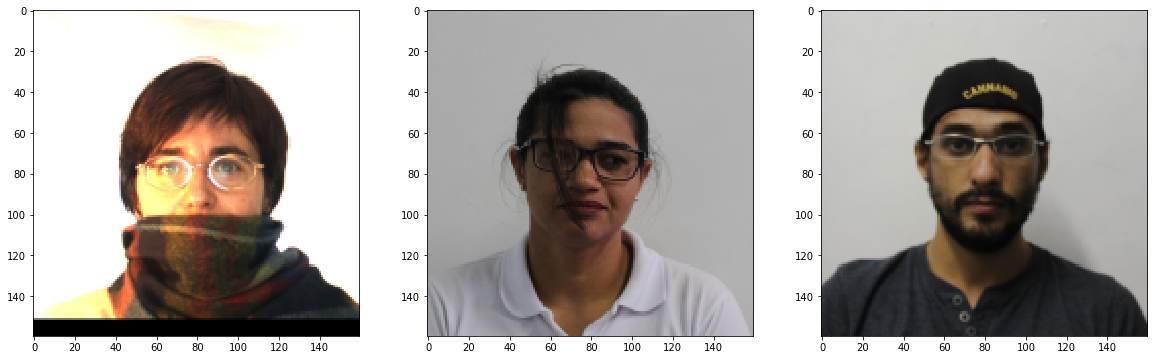

In [35]:
(anc, pos, neg), _ = valid_gen.__getitem__(None)

emb_anc = req_model.predict(anc)
emb_pos = req_model.predict(pos)
emb_neg = req_model.predict(neg)

pos_dist = np.sum((emb_anc - emb_pos) ** 2)
neg_dist = np.sum((emb_anc - emb_neg) ** 2)
loss = np.maximum(0.0, pos_dist - neg_dist + 0.2)

print(pos_dist)
print(neg_dist)

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.imshow((anc.squeeze()*255).astype(np.uint8)[:, :, ::-1])

plt.subplot(1, 3, 2)
plt.imshow((pos.squeeze()*255).astype(np.uint8)[:, :, ::-1])

plt.subplot(1, 3, 3)
plt.imshow((neg.squeeze()*255).astype(np.uint8)[:, :, ::-1])

In [22]:
anc.max()

0.93725497